Phần 1: Explore Data Analysis

In [ ]:
# 1. Gỡ cài đặt Numpy hiện tại và cài bản cũ (<2.0)
!pip uninstall -y numpy
!pip install "numpy<2.0"


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=

In [ ]:

# 2. Cài đặt thư viện surprise
!pip install scikit-surprise

1. Thư viện cần thiết

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import copy
import tqdm
from collections import Counter

# Import các module của Surprise
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold

# Kiểm tra phiên bản Numpy (nếu < 2.0 là thành công)
print(f"NumPy version: {np.__version__}")

# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')

NumPy version: 1.26.4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Đọc dữ liệu

In [ ]:
ratings = pd.read_csv(r"drive/My Drive/ratings.dat", sep = "::", encoding="cp1252")
ratings.columns = ['userid', 'movieid', 'rating', 'timestamp']
movies = pd.read_csv(r"drive/My Drive/movies.dat", sep = "::", encoding="cp1252")
movies.columns = ['movieid', 'title', 'genres']
users = pd.read_csv(r"drive/My Drive/users.dat", sep = "::", encoding="cp1252")
users.columns = ['userid','gender','age','occupation','zip-code']

3. Một số phân tích về dữ liệu ratings

a) Kiểm tra có giá trị rỗng (null) không

In [ ]:

ratings['userid'].isnull().sum()
ratings['movieid'].isnull().sum()
ratings['rating'].isnull().sum()
ratings['timestamp'].isnull().sum()

0

b) Kiểm tra và loại bỏ các giá trị rating không hợp lệ (Giá trị hợp lệ từ 1 tới 5)

In [ ]:

ratings = ratings[(ratings['rating'] >= 1) & (ratings['rating'] <= 5)]
ratings

,userid,movieid,rating,timestamp
0,1,661,3,978302109
1,1,914,3,978301968
2,1,3408,4,978300275
3,1,2355,5,978824291
4,1,1197,3,978302268
...,...,...,...,...
1000203,6040,1091,1,956716541
1000204,6040,1094,5,956704887
1000205,6040,562,5,956704746
1000206,6040,1096,4,956715648


c) Tính trung bình, trung vị, tứ phân vị của cột rating

In [ ]:
mean_rating = ratings['rating'].mean()
median_rating = ratings['rating'].median()
q1 = ratings['rating'].quantile(0.25)
q3 = ratings['rating'].quantile(0.75)

print(f'Mean Rating: {mean_rating}')
print(f'Median Rating: {median_rating}')
print(f'First Quartile (Q1): {q1}')
print(f'Third Quartile (Q3): {q3}')

Mean Rating: 3.581563034888743
Median Rating: 4.0
First Quartile (Q1): 3.0
Third Quartile (Q3): 4.0


d) Biểu đồ cột rating

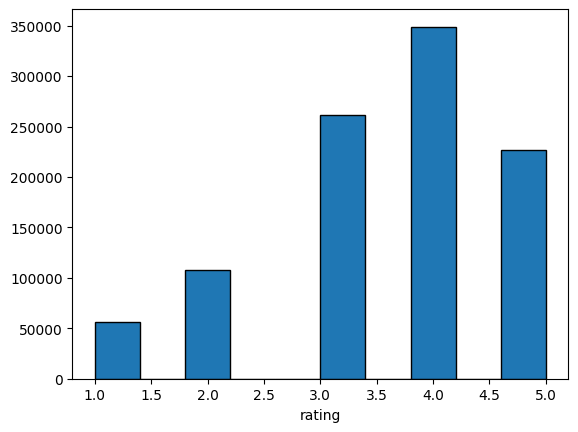

In [ ]:

plt.hist(ratings['rating'], bins=10, edgecolor='black')

plt.xlabel('rating')
plt.show()

e) Biểu đồ hộp về rating để kiểm tra xem có outlier không

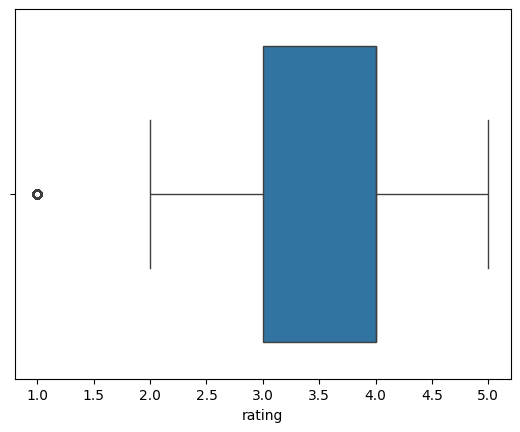

In [ ]:
sns.boxplot(x=ratings['rating'])
plt.show()


4. Một số phân tích về dữ liệu movie

a) Kiểm tra movies dataframe có giá trị rỗng không

In [ ]:
movies['movieid'].isnull().sum()
movies['title'].isnull().sum()
movies['genres'].isnull().sum()

0

b) Biểu đồ phân bố các phim theo năm

In [ ]:
movies['year'] = movies['title'].str[-5:-1].astype(int)
movies['title'] = movies['title'].str[:-7]
movies

,movieid,title,genres,year
0,2,Jumanji,Adventure|Children's|Fantasy,1995
1,3,Grumpier Old Men,Comedy|Romance,1995
2,4,Waiting to Exhale,Comedy|Drama,1995
3,5,Father of the Bride Part II,Comedy,1995
4,6,Heat,Action|Crime|Thriller,1995
...,...,...,...,...
3877,3948,Meet the Parents,Comedy,2000
3878,3949,Requiem for a Dream,Drama,2000
3879,3950,Tigerland,Drama,2000
3880,3951,Two Family House,Drama,2000


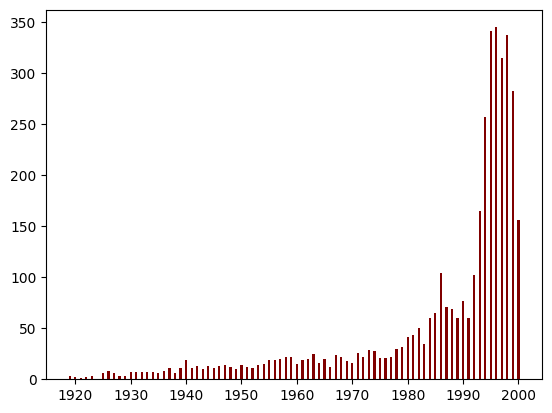

In [ ]:

test = Counter(movies['year'])
x = test.keys()
y = test.values()

plt.bar(x,y, color ='maroon', width = 0.4)
plt.show()

c) Chia thuộc tính genres (thể loại) thành nhiều cột có thể loại khác nhau để phân tích

In [ ]:
def extract_info(string):
    x = re.split("(\d4)$",string)
    return x[:2]

In [ ]:

def genre_extract(string):
    return re.split("\|",string)

In [ ]:
def all_genre_creating(movies):
    uniqe_genres = []
    for string in movies['genres']:
        array = genre_extract(string)
        for genre in array:
            if genre not in uniqe_genres and genre != '(no genres listed)':
                uniqe_genres.append(genre)
    return uniqe_genres

In [ ]:
def movie_profiling(movies):
    # 1. Tạo danh sách các thể loại duy nhất
    uniqe_genres = all_genre_creating(movies)
    movie_profile = copy.deepcopy(movies)

    # 2. Khởi tạo các cột thể loại với giá trị 0
    for genre in uniqe_genres :
        movie_profile[genre] = 0

    # 3. Gán giá trị 1 cho các thể loại tương ứng (One-Hot Encoding)
    loc = 0
    for string in movie_profile['genres']:
        for genre in genre_extract(string):
            if genre in uniqe_genres:
                # Sử dụng .loc để tránh cảnh báo SettingWithCopyWarning
                movie_profile.loc[loc, genre] = 1
        loc = loc + 1

    # 4. Loại bỏ các cột không cần thiết: 'title', 'genres', và THÊM 'year'
    columns_to_drop = ['title', 'genres', 'year']

    # Kiểm tra xem cột 'year' có tồn tại để tránh lỗi nếu chưa chạy EDA
    if 'year' in movie_profile.columns:
        movie_profile = movie_profile.drop(columns=columns_to_drop).set_index('movieid')
    else:
        # Nếu chưa có 'year', chỉ drop 2 cột kia
        movie_profile = movie_profile.drop(columns=['title', 'genres']).set_index('movieid')

    return movie_profile

In [ ]:
movie_profile = movie_profiling(movies)
movie_profile

,Adventure,Children's,Fantasy,Comedy,Romance,Drama,Action,Crime,Thriller,Horror,Animation,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
movieid,,,,,,,,,,,,,,,,,,
2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3948,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3949,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3950,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


d) Vẽ biểu đồ tròn để phân tích các bộ phim thường sản xuất theo thể loại gì

In [ ]:

genre_counts = movie_profile.sum()
print(genre_counts)


Adventure       283
Children's      250
Fantasy          68
Comedy         1199
Romance         471
Drama          1603
Action          503
Crime           211
Thriller        492
Horror          343
Animation       104
Sci-Fi          276
Documentary     127
War             143
Musical         114
Mystery         106
Film-Noir        44
Western          68
dtype: int64


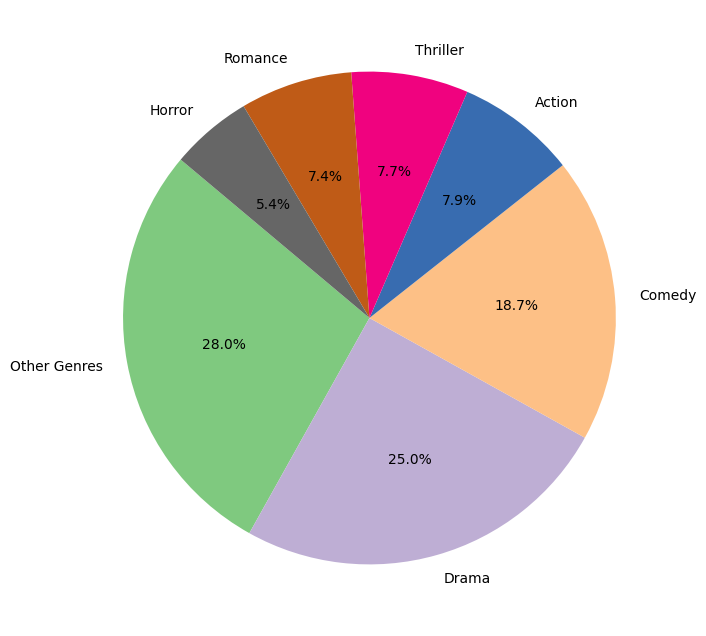

In [ ]:

labels = genre_counts.index
sizes = genre_counts.values
total_count = sizes.sum()

threshold_percentage = 5
small_genres = sizes / total_count * 100 < threshold_percentage
other_genres_count = sizes[small_genres].sum()
mask_large_genres = ~small_genres

labels = labels[mask_large_genres].tolist() + ['Other Genres']
sizes = sizes[mask_large_genres].tolist() + [other_genres_count]

sorted_indices = sorted(range(len(sizes)), key=lambda k: sizes[k], reverse=True)
labels = [labels[i] for i in sorted_indices]
sizes = [sizes[i] for i in sorted_indices]

colormap = cm.get_cmap('Accent', len(labels))

plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colormap(range(len(labels))))
plt.show()

Một số phân tích về dữ liệu users

Mục đích:

Thống kê về số lượng rating theo giới tính và thể loại
Để tìm ra người dùng ở độ tuổi nào thích xem phim thể loại gì

In [ ]:
bins = [0, 25, 30, 45, float('inf')]
labels = ['<=24', '25-30', '31-45', '>=45']

users['age_bin'] = pd.cut(users['age'], bins=bins, labels=labels, right=False)
users = users[['userid', 'gender', 'age', 'occupation', 'zip-code','age_bin']]
users

,userid,gender,age,occupation,zip-code,age_bin
0,2,M,56,16,70072,>=45
1,3,M,25,15,55117,25-30
2,4,M,45,7,02460,>=45
3,5,M,25,20,55455,25-30
4,6,F,50,9,55117,>=45
...,...,...,...,...,...,...
6034,6036,F,25,15,32603,25-30
6035,6037,F,45,1,76006,>=45
6036,6038,F,56,1,14706,>=45
6037,6039,F,45,0,01060,>=45


In [ ]:

users['userid'].isnull().sum()
users['gender'].isnull().sum()
users['age'].isnull().sum()
users['occupation'].isnull().sum()
users['zip-code'].isnull().sum()


0

a) Ghép hai df users và rating lại thành một

In [ ]:
merged_data = pd.merge(ratings, users[['userid', 'gender', 'age_bin']], on='userid')
ratings_users = merged_data[['userid', 'gender', 'age_bin', 'movieid', 'rating']]
ratings_users

,userid,gender,age_bin,movieid,rating
0,2,M,>=45,1357,5
1,2,M,>=45,3068,4
2,2,M,>=45,1537,4
3,2,M,>=45,647,3
4,2,M,>=45,2194,4
...,...,...,...,...,...
1000151,6040,M,25-30,1091,1
1000152,6040,M,25-30,1094,5
1000153,6040,M,25-30,562,5
1000154,6040,M,25-30,1096,4


b) Tính toán điểm rating trung bình của phim dựa trên độ tuổi và giới tính

In [ ]:

merged_data = pd.merge(ratings_users, movie_profile, on='movieid')
movie_avg_ratings = merged_data.groupby(['movieid', 'age_bin', 'gender'])['rating'].mean().reset_index()
movie_avg_ratings

,movieid,age_bin,gender,rating
0,2,<=24,F,3.103448
1,2,<=24,M,3.053030
2,2,25-30,F,3.352941
3,2,25-30,M,3.095238
4,2,31-45,F,3.400000
...,...,...,...,...
29635,3952,25-30,M,3.766355
29636,3952,31-45,F,3.500000
29637,3952,31-45,M,3.781818
29638,3952,>=45,F,4.000000


c) Từ phần b, Tính toán điểm rating trung bình của các thể loại dựa trên độ tuổi và giới tính, và điểm trung bình phim

In [ ]:

merged_data = pd.merge(movie_avg_ratings, movie_profile, on='movieid')
melted_df = pd.melt(merged_data, id_vars=['age_bin', 'gender', 'movieid', 'rating'], var_name='genre', value_name='genre_value')
filtered_df = melted_df[melted_df['genre_value'] == 1]
genres_ratings = filtered_df.groupby(['age_bin', 'gender', 'genre'])['rating'].mean().reset_index()

genres_ratings


,age_bin,gender,genre,rating
0,<=24,F,Action,2.957983
1,<=24,F,Adventure,3.086805
2,<=24,F,Animation,3.362932
3,<=24,F,Children's,3.071854
4,<=24,F,Comedy,3.221092
...,...,...,...,...
139,>=45,M,Romance,3.342208
140,>=45,M,Sci-Fi,3.114290
141,>=45,M,Thriller,3.278739
142,>=45,M,War,3.674794


d) Tạo dataframe (genre_data) thống kê về điểm trung bình của các thể loại dựa trên độ tuổi và giới tính

In [ ]:

genre_data = genres_ratings.pivot_table(index=['age_bin', 'gender'], columns='genre', values='rating', aggfunc='mean')
genre_data = genre_data.drop(columns=genre_data.filter(like='Film-Noir').columns)
genre_data.reset_index(inplace=True)

genre_data

genre,age_bin,gender,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,<=24,F,2.957983,3.086805,3.362932,3.071854,3.221092,3.343403,3.831511,3.433037,3.063737,2.760251,3.523932,3.442150,3.381224,3.014737,3.125262,3.483695,3.230412
1,<=24,M,3.109898,3.003829,3.229570,2.761746,3.095603,3.362664,3.506409,3.299284,3.006655,2.791237,3.020058,3.385396,3.219917,3.071853,3.194792,3.515644,3.229569
2,25-30,F,3.078027,3.106851,3.406673,3.147753,3.233104,3.383203,3.837103,3.485803,3.231734,2.648175,3.664375,3.423702,3.416299,2.933501,3.252150,3.567798,3.326724
3,25-30,M,3.049853,3.035352,3.322708,2.872709,3.091346,3.375691,3.746593,3.380369,2.966147,2.782345,3.332163,3.456514,3.241651,3.067979,3.241516,3.498322,3.585052
4,31-45,F,3.181350,3.282265,3.385342,3.337272,3.325984,3.400665,3.586618,3.554419,3.308343,2.765857,3.618970,3.434627,3.510797,3.098179,3.191325,3.692762,3.511244
5,31-45,M,3.137080,3.132654,3.359943,3.043839,3.144945,3.392256,3.960466,3.470109,3.063765,2.731978,3.402061,3.384523,3.331332,3.084555,3.271734,3.554284,3.486056
6,>=45,F,3.195497,3.259405,3.542743,3.289824,3.284359,3.456798,3.943208,3.630953,3.322904,2.803500,3.607080,3.576449,3.508619,3.068172,3.354346,3.724020,3.503725
7,>=45,M,3.122996,3.178601,3.393141,3.088076,3.203636,3.432480,3.590276,3.524035,3.210034,2.566405,3.509611,3.461561,3.342208,3.114290,3.278739,3.674794,3.495592


e) Thống kê về số lượng rating theo giới tính và thể loại

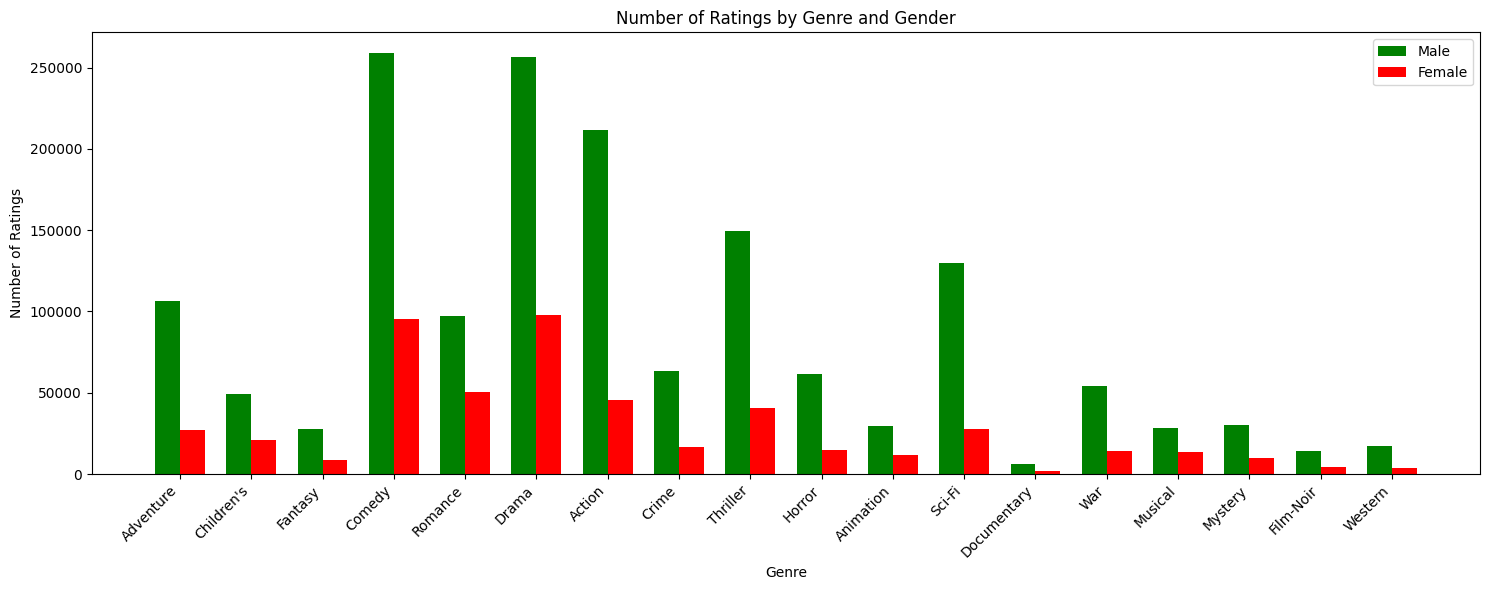

In [ ]:

merged = pd.merge(ratings, users[['userid', 'gender']], on='userid')
final = pd.merge(merged, movie_profile, on='movieid')
genre_ratings = final.groupby('gender').sum().loc[:, 'Adventure':'Western']

fig, ax = plt.subplots(figsize=(15, 6))

bar_width = 0.35
bar_positions = range(len(genre_ratings.columns))

ax.bar(bar_positions, genre_ratings.loc['M'], bar_width, label='Male', color='green')
ax.bar([pos + bar_width for pos in bar_positions], genre_ratings.loc['F'], bar_width, label='Female', color='red')
ax.set_xlabel('Genre')
ax.set_ylabel('Number of Ratings')
ax.set_title('Number of Ratings by Genre and Gender')
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions])
ax.set_xticklabels(genre_ratings.columns, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

f) Vẽ biểu đồ heatmap từ dataframe (genre_data) trên

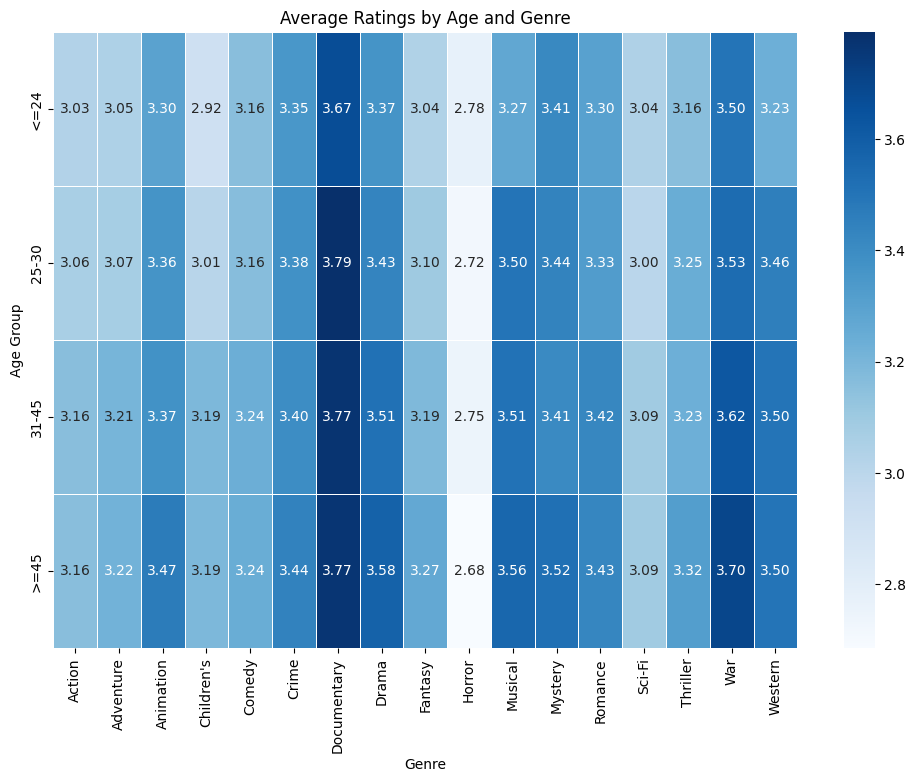

In [ ]:
heatmap_data = genres_ratings.pivot_table(index='age_bin', columns='genre', values='rating', aggfunc='mean')
heatmap_data_filtered = heatmap_data.drop(columns=['Film-Noir'], errors='ignore')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_filtered, cmap='Blues', annot=True, fmt=".2f", linewidths=.5)
plt.title('Average Ratings by Age and Genre')
plt.xlabel('Genre')
plt.ylabel('Age Group')
plt.show()

Phần 2: Recommendation System sử dụng Collaborative Filtering và Content Filtering

1. Collaborative Filtering

In [ ]:
reader = Reader()

data = Dataset.load_from_df(ratings[['userid', 'movieid', 'rating']], reader)
kf = KFold(n_splits=5)
kf.split(data)

svd = SVD()
trainset = data.build_full_trainset()
svd.fit(trainset)

testset = trainset.build_anti_testset()

In [ ]:
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8742  0.8726  0.8709  0.8754  0.8752  0.8737  0.0017  
MAE (testset)     0.6863  0.6853  0.6846  0.6870  0.6867  0.6860  0.0009  
Fit time          19.09   17.19   17.44   16.81   16.16   17.34   0.98    
Test time         3.34    3.25    2.71    3.62    4.24    3.43    0.50    


{'test_rmse': array([0.87424048, 0.87256631, 0.87087475, 0.87540535, 0.87522744]),
 'test_mae': array([0.68625353, 0.68526904, 0.68460161, 0.68698006, 0.68674235]),
 'fit_time': (19.08636212348938,
  17.18763041496277,
  17.44183087348938,
  16.810664176940918,
  16.15528702735901),
 'test_time': (3.3381245136260986,
  3.2507681846618652,
  2.708327054977417,
  3.6228253841400146,
  4.239177227020264)}

In [ ]:
predictions = svd.test(testset)

In [ ]:
accuracy.rmse(predictions)

RMSE: 0.6829


0.6829498323567992

In [ ]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=3.995498613892329, details={'was_impossible': False})

2. Content-based Filtering

In [ ]:
ratings = ratings.drop(columns = ['timestamp'])
movie_profile = movie_profile.drop(columns=['year'])

# user profile
user_x_movie = pd.pivot_table(ratings, values='rating', index=['movieid'], columns = ['userid'])
user_x_movie.sort_index(axis=0, inplace=True)
userIDs = user_x_movie.columns
user_profile = pd.DataFrame(columns = movie_profile.columns)

for i in range(len(user_x_movie.columns)):
  working_df = movie_profile.mul(user_x_movie.iloc[:,i], axis=0)
  user_profile.loc[userIDs[i]] = working_df.mean(axis=0)

# TFIDF
df = movie_profile.sum()
idf = (len(movies)/df).apply(np.log)
TFIDF = movie_profile.mul(idf.values)

# recommendation
df_predict = pd.DataFrame()

for i in range(len(user_x_movie.columns)):
  working_df = TFIDF.mul(user_profile.iloc[i], axis=1)
  df_predict[user_x_movie.columns[i]] = working_df.sum(axis=1)

In [ ]:
TFIDF

In [ ]:
df_predict = df_predict.reset_index()
df_predict

In [ ]:
def recommender(user_no):
    # user predicted rating to all films
    user_predicted_rating = df_predict[['movieid', df_predict.columns[user_no]]]
    # combine film rating and film detail
    user_rating_film = movies.merge(user_predicted_rating, left_on='movieid', right_on= 'movieid')
    # films already watched by user
    already_watched = ratings[ratings['userid'].isin([user_no])]['movieid']
    # recommendation without films being watched by user
    all_rec = user_rating_film[~user_rating_film.index.isin(already_watched)]
    return all_rec.sort_values(by=user_no, ascending=False, axis=0).iloc[0:10][['movieid', 'title']]

In [ ]:
recommended_movies = recommender(int(3))

In [ ]:
print(recommended_movies)